In [102]:
# Cell 0 - Imports e configurazioni
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from joblib import Parallel, delayed

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score
from sklearn.metrics import silhouette_score

# tslearn
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import cdist_dtw
from tslearn.utils import to_time_series_dataset

# hierarchical
from scipy.cluster.hierarchy import linkage, fcluster

# catch22
from pycatch22 import catch22_all

# umap
import umap

# settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# plotting style
sns.set(style="whitegrid")


In [103]:
# Cell 1 - Load
DATA_PATH = "/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv"  
df = pd.read_csv(DATA_PATH)
print("Shape df:", df.shape)
display(df.head())

# Extract time series columns (0..99)
ts_cols = [str(i) for i in range(100)]
X_raw = df[ts_cols].values.astype(float)  # shape (n_samples, 100)
n_samples, ts_len = X_raw.shape
print("n_samples, ts_len:", n_samples, ts_len)

# Metadata
# genre is stored as string list like "['Action', 'Adventure']" -> extract main_genre
def safe_main_genre(g):
    if isinstance(g, str):
        try:
            lst = eval(g)
            return lst[0] if len(lst)>0 else "Unknown"
        except Exception:
            return g
    return g

df['main_genre'] = df['genre'].apply(safe_main_genre)
meta = df[['main_genre', 'rating', 'rating_category', 'id']].copy()


Shape df: (1134, 104)


,id,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,rating,genre,rating_category
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,10709.0,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,637.0,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,6784.0,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,21094.0,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,88635.0,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High


n_samples, ts_len: 1134 100


In [104]:
# Cell 2 - Preprocessing
# We'll keep three versions:
# X_raw (original), X_log (log1p), X_z (z-score per series of log)
X_log = np.log1p(X_raw)

# z-score per serie (row-wise). If std==0, subtract mean only.
def zscore_rows(arr):
    means = arr.mean(axis=1, keepdims=True)
    stds = arr.std(axis=1, keepdims=True)
    stds[stds==0] = 1.0
    return (arr - means) / stds

X_z = zscore_rows(X_log)

print("Prepared X_raw.shape, X_log.shape, X_z.shape:", X_raw.shape, X_log.shape, X_z.shape)


Prepared X_raw.shape, X_log.shape, X_z.shape: (1134, 100) (1134, 100) (1134, 100)


In [105]:
# Cell 3 - catch22 extraction (may take ~a minute)
start = time.time()
catch22_feats = []
for ts in tqdm(X_raw):
    catch22_feats.append(catch22_all(ts)['values'])
catch22_feats = np.array(catch22_feats)  # (n_samples, 22)
print("catch22_feats shape:", catch22_feats.shape, "time(s):", time.time()-start)

# scale features
scaler_feats = StandardScaler().fit(catch22_feats)
features_scaled = scaler_feats.transform(catch22_feats)


100%|██████████| 1134/1134 [00:00<00:00, 2165.83it/s]

catch22_feats shape: (1134, 22) time(s): 0.5295100212097168


In [ ]:
# def local_features(ts, window=5):
#     n = len(ts)
#     features = {}
#     mov_mean = np.convolve(ts, np.ones(window)/window, mode='valid')
#     features['mov_mean_mean'] = np.mean(mov_mean)
#     features['mov_mean_std'] = np.std(mov_mean)
#     features['local_max'] = np.max(ts)
#     features['local_min'] = np.min(ts)
#     ranges = [ts[i:i+window].max()-ts[i:i+window].min() for i in range(n-window+1)]
#     features['mean_range'] = np.mean(ranges)
#     return list(features.values())

# def spectral_features(ts):
#     fft_vals = np.fft.fft(ts)
#     fft_mag = np.abs(fft_vals[:len(fft_vals)//2])
#     features = [np.mean(fft_mag), np.std(fft_mag), np.max(fft_mag)]
#     return features

# def derivative_features(ts):
#     deriv = np.diff(ts)
#     features = [np.mean(deriv), np.std(deriv), np.max(deriv), np.min(deriv)]
#     return features

# # Combina catch22 + feature aggiuntive
# combined_features = []
# for ts in reps:  # reps = array (k_stage1, ts_len)
#     ts = ts.astype(float)
#     f_catch22 = catch22_all(ts)['values']      # 22 feature
#     f_local = local_features(ts)               # 5 feature
#     f_spectral = spectral_features(ts)         # 3 feature
#     f_deriv = derivative_features(ts)          # 4 feature
#     combined = np.hstack([f_catch22, f_local, f_spectral, f_deriv])
#     combined_features.append(combined)

# combined_features = np.vstack(combined_features)
# print("Shape combined features:", combined_features.shape)

# scaler = StandardScaler()
# combined_features_scaled = scaler.fit_transform(combined_features)

# print("Shape scaled features:", combined_features_scaled.shape)

Shape combined features: (200, 34)
Shape scaled features: (200, 34)


In [111]:
# Cell 4 - Preliminary micro-clustering
from sklearn.cluster import KMeans

k_stage1 = 200
print("k_stage1:", k_stage1)
km_stage1 = KMeans(n_clusters=k_stage1, random_state=RANDOM_STATE, n_init=10)
start = time.time()
prelim_labels = km_stage1.fit_predict(features_scaled)  # or combined_features_scaled !!!
print("Prelim clustering done in", time.time()-start, "s")

# cluster -> indices mapping
cluster_to_idx = {c: np.where(prelim_labels==c)[0] for c in np.unique(prelim_labels)}
# Quick stats
sizes = [len(cluster_to_idx[c]) for c in cluster_to_idx]
print("Micro-cluster sizes: min, median, mean, max ->", np.min(sizes), np.median(sizes), np.mean(sizes), np.max(sizes))


k_stage1: 200
Prelim clustering done in 0.4777958393096924 s
Micro-cluster sizes: min, median, mean, max -> 1 3.5 5.67 27


In [112]:
# Cell 5 - compute medoids + PAA (parallel)
from tslearn.metrics import cdist_dtw

def paa(ts, segments=20):
    n = len(ts)
    if segments >= n:
        return ts.copy()
    out = np.zeros(segments)
    for i in range(segments):
        start = int(np.floor(i*n/segments))
        end = int(np.floor((i+1)*n/segments))
        if end<=start: end = start+1
        out[i] = ts[start:end].mean()
    return out

def medoid_of_members(members):
    # members: array (m, L)
    if len(members) == 1:
        return members[0]
    D = cdist_dtw(members)  # dtw distances (m,m)
    return members[D.sum(axis=1).argmin()]

# Parameters
paa_segments = 20
n_jobs = 6

def process_cluster(c):
    idx = cluster_to_idx[c]
    members = X_z[idx]   # use normalized log series for medoid (focus on shape)
    rep = medoid_of_members(members)
    rep_paa = paa(rep, segments=paa_segments)
    return c, rep_paa

start = time.time()
results = Parallel(n_jobs=n_jobs)(delayed(process_cluster)(c) for c in tqdm(cluster_to_idx.keys()))
reps_ordered = sorted(results, key=lambda x: x[0])
rep_order, reps = zip(*reps_ordered)
reps = np.vstack(reps)  # shape (k_stage1, paa_segments)
print("Computed reps shape:", reps.shape, "time(s):", time.time()-start)


100%|██████████| 200/200 [00:03<00:00, 55.60it/s] 


Computed reps shape: (200, 20) time(s): 4.0299272537231445


Testing k = 3
 - fitted in 7.0s, inertia=1.59
 - silhouette(sample) =  0.5113093875854111
Testing k = 4
 - fitted in 6.4s, inertia=1.42
 - silhouette(sample) =  0.43516087296418265
Testing k = 5
 - fitted in 7.8s, inertia=1.31
 - silhouette(sample) =  0.17485458138036075
Testing k = 6
 - fitted in 11.5s, inertia=1.28
 - silhouette(sample) =  0.15833275470699618
Testing k = 7
 - fitted in 12.3s, inertia=1.21
 - silhouette(sample) =  0.14981202998986887
Testing k = 8
 - fitted in 9.8s, inertia=1.12
 - silhouette(sample) =  0.10723793800873571
Testing k = 9
 - fitted in 10.4s, inertia=1.06
 - silhouette(sample) =  0.10669524545107943
Testing k = 10
 - fitted in 11.4s, inertia=1.01
 - silhouette(sample) =  0.1093801249788514
Testing k = 11
 - fitted in 11.9s, inertia=0.98
 - silhouette(sample) =  0.10900547465146315
Testing k = 12
 - fitted in 8.3s, inertia=0.95
 - silhouette(sample) =  0.10257224825063428


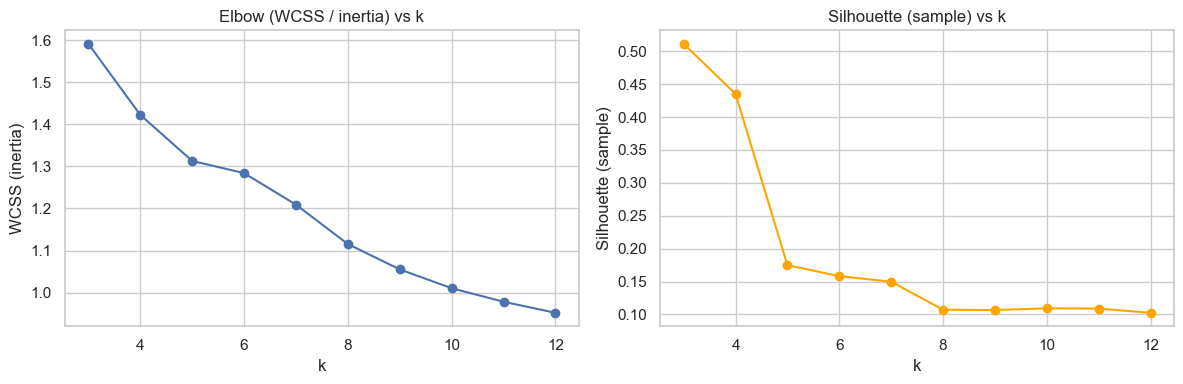

In [113]:
# Cell 6 - choose k_final using Elbow (inertia) and sample-based silhouette
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw

k_range = list(range(3, 13))
wcss = []
sil_scores_sample = []
sample_size = min(300, len(reps))  # sample for silhouette if needed

# convert reps to tslearn dataset (some tslearn utils expect 3D arrays)
reps_ts = to_time_series_dataset(reps)  # shape (k_stage1, paa_segments, 1) possibly

for k in k_range:
    print("Testing k =", k)
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=30, random_state=RANDOM_STATE)
    start = time.time()
    labels_k = km.fit_predict(reps_ts)
    t_elapsed = time.time()-start
    print(f" - fitted in {t_elapsed:.1f}s, inertia={km.inertia_:.2f}")
    wcss.append(km.inertia_)
    # silhouette on sample using DTW distances (precomputed)
    # sample indices from reps
    sample_idx = np.random.choice(len(reps), sample_size, replace=False)
    D_sample = cdist_dtw(reps[sample_idx])  # pairwise DTW among sample
    labels_sample = labels_k[sample_idx]
    sil = silhouette_score(D_sample, labels_sample, metric="precomputed")
    sil_scores_sample.append(sil)
    print(" - silhouette(sample) = ", sil)

# Plot WCSS and Silhouette(sample)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow (WCSS / inertia) vs k")
plt.xlabel("k"); plt.ylabel("WCSS (inertia)")

plt.subplot(1,2,2)
plt.plot(k_range, sil_scores_sample, marker='o', color='orange')
plt.title("Silhouette (sample) vs k")
plt.xlabel("k"); plt.ylabel("Silhouette (sample)")
plt.tight_layout()
plt.show()


In [114]:
# Cell 7 - final clustering (choose k_final from inspection)
k_final = 8  # sostituisci con il valore che scegli dal plot
print("k_final chosen:", k_final)

km_final = TimeSeriesKMeans(n_clusters=k_final, metric="dtw", max_iter=50, random_state=RANDOM_STATE)
labels_reps_dtw = km_final.fit_predict(reps_ts)  # labels for each representative (len = k_stage1)
print("Done TimeSeriesKMeans on reps; inertia:", km_final.inertia_)

# Map micro->final labels and propagate to full dataset
micro_to_final = dict(zip(rep_order, labels_reps_dtw))
labels_final_full = np.array([micro_to_final[l] for l in prelim_labels])  # per ogni film
df['cluster_final_dtw'] = labels_final_full


k_final chosen: 8
Done TimeSeriesKMeans on reps; inertia: 1.1153850030247316


In [115]:
# Cell 8 - Agglomerative clustering over reps using DTW distances
D_reps = cdist_dtw(reps)  # cost: k_stage1^2, ma k_stage1 ~200 -> OK
Z = linkage(D_reps, method='average')  # linkage from scipy works with condensed/dist? it accepts full matrix for input? -> we pass flattened cond.
# NOTE: linkage expects condensed distance matrix; we convert:
from scipy.spatial.distance import squareform
D_condensed = squareform(D_reps, checks=False)
Z = linkage(D_condensed, method='average')  # uses condensed form
# cut tree into k_final clusters
labels_reps_agg = fcluster(Z, k_final, criterion='maxclust') - 1  # 0-based
# propagate to full dataset
micro_to_final_agg = dict(zip(rep_order, labels_reps_agg))
labels_final_full_agg = np.array([micro_to_final_agg[l] for l in prelim_labels])
df['cluster_final_agg'] = labels_final_full_agg

print("Agglomerative labels (reps) unique:", np.unique(labels_reps_agg))


/opt/anaconda3/lib/python3.12/site-packages/tslearn/metrics/dtw_variants.py:1749: SyntaxWarning: invalid escape sequence '\d'
  """Compute the mask (region constraint).


KeyboardInterrupt: 

In [ ]:
# Cell 9 - Evaluate clusters vs metadata
from sklearn.metrics import adjusted_rand_score

def purity_score(y_true, y_pred):
    cm = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(cm.values, axis=0)) / cm.values.sum()

# ARI vs main_genre (use main_genre)
ari_dtw = adjusted_rand_score(df['main_genre'], df['cluster_final_dtw'])
purity_rating_dtw = purity_score(df['rating_category'], df['cluster_final_dtw'])
db_dtw = davies_bouldin_score(reps.reshape(len(reps), -1), labels_reps_dtw)  # DB on reps as vectors

print("DTW (stage2) - ARI(main_genre):", ari_dtw)
print("DTW (stage2) - Purity(rating_category):", purity_rating_dtw)
print("DTW (stage2) - Davies-Bouldin (reps):", db_dtw)

# Agglomerative metrics
ari_agg = adjusted_rand_score(df['main_genre'], df['cluster_final_agg'])
purity_rating_agg = purity_score(df['rating_category'], df['cluster_final_agg'])
db_agg = davies_bouldin_score(reps.reshape(len(reps), -1), labels_reps_agg)

print("Agg (stage2) - ARI:", ari_agg)
print("Agg (stage2) - Purity rating:", purity_rating_agg)
print("Agg (stage2) - DB:", db_agg)

# Silhouette (precomputed DTW) on reps for the selected k_final (expensive but reps small)
D_reps = cdist_dtw(reps)
sil_reps_dtw = silhouette_score(D_reps, labels_reps_dtw, metric="precomputed")
sil_reps_agg = silhouette_score(D_reps, labels_reps_agg, metric="precomputed")
print("Silhouette (DTW) reps - KMeans:", sil_reps_dtw, "Agg:", sil_reps_agg)


DTW (stage2) - ARI(main_genre): 0.049304360839144704
DTW (stage2) - Purity(rating_category): 0.4514991181657848
DTW (stage2) - Davies-Bouldin (reps): 1.9193988418709165
Agg (stage2) - ARI: 0.04601647879535873
Agg (stage2) - Purity rating: 0.4523809523809524
Agg (stage2) - DB: 1.0038452371431341
Silhouette (DTW) reps - KMeans: 0.17485458138036072 Agg: 0.4778846267056434


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


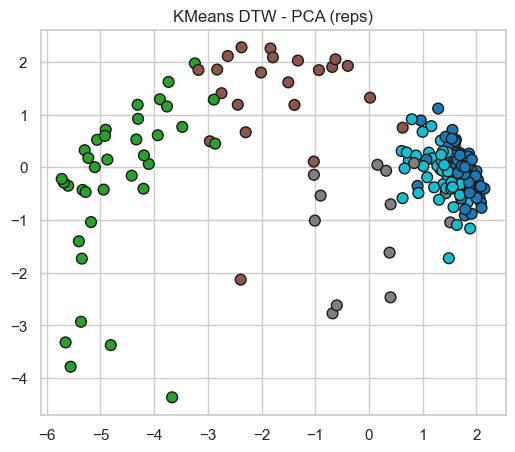

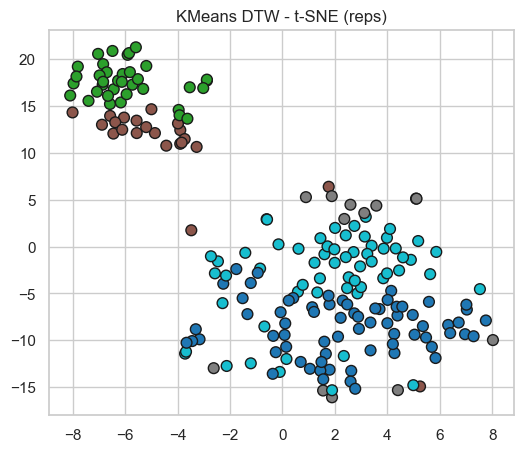

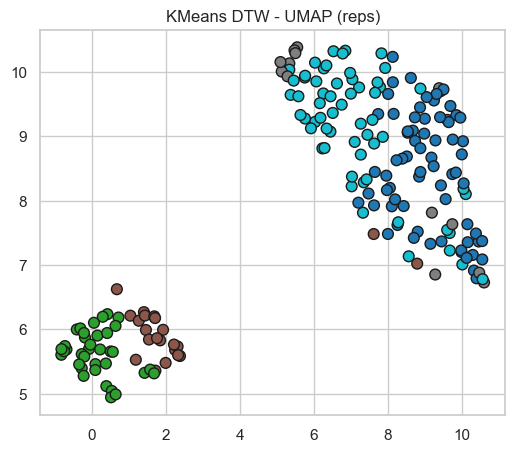

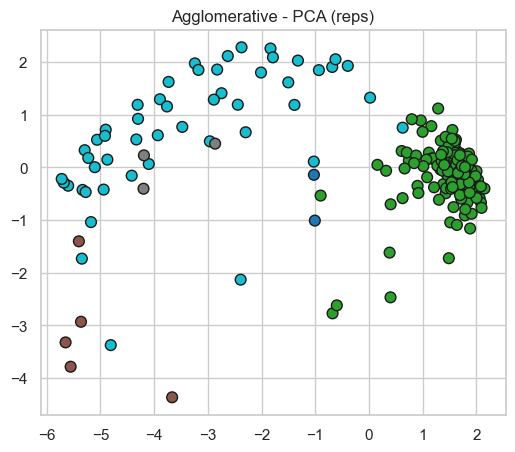

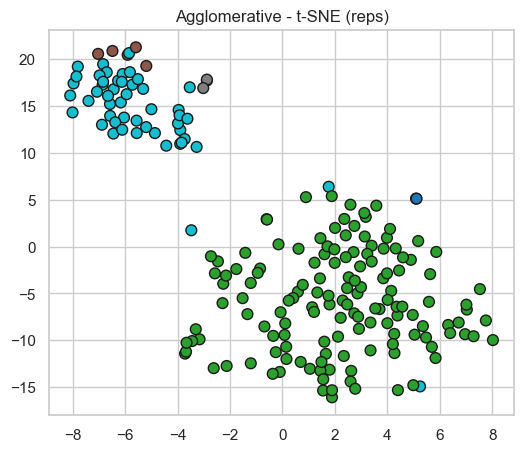

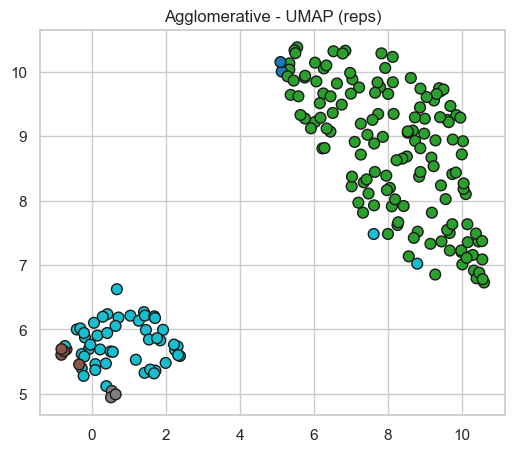

In [ ]:
# Cell 10 - Visualizations for representatives
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
reps_pca = pca.fit_transform(reps)

# t-SNE (might be slower)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
reps_tsne = tsne.fit_transform(reps)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
reps_umap = reducer.fit_transform(reps)

def plot_embedding(X_emb, labels, title):
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_emb[:,0], X_emb[:,1], c=labels, cmap='tab10', s=60, edgecolor='k')
    plt.title(title)
    plt.show()

# KMeans DTW reps
plot_embedding(reps_pca, labels_reps_dtw, "KMeans DTW - PCA (reps)")
plot_embedding(reps_tsne, labels_reps_dtw, "KMeans DTW - t-SNE (reps)")
plot_embedding(reps_umap, labels_reps_dtw, "KMeans DTW - UMAP (reps)")

# Agglomerative reps
plot_embedding(reps_pca, labels_reps_agg, "Agglomerative - PCA (reps)")
plot_embedding(reps_tsne, labels_reps_agg, "Agglomerative - t-SNE (reps)")
plot_embedding(reps_umap, labels_reps_agg, "Agglomerative - UMAP (reps)")


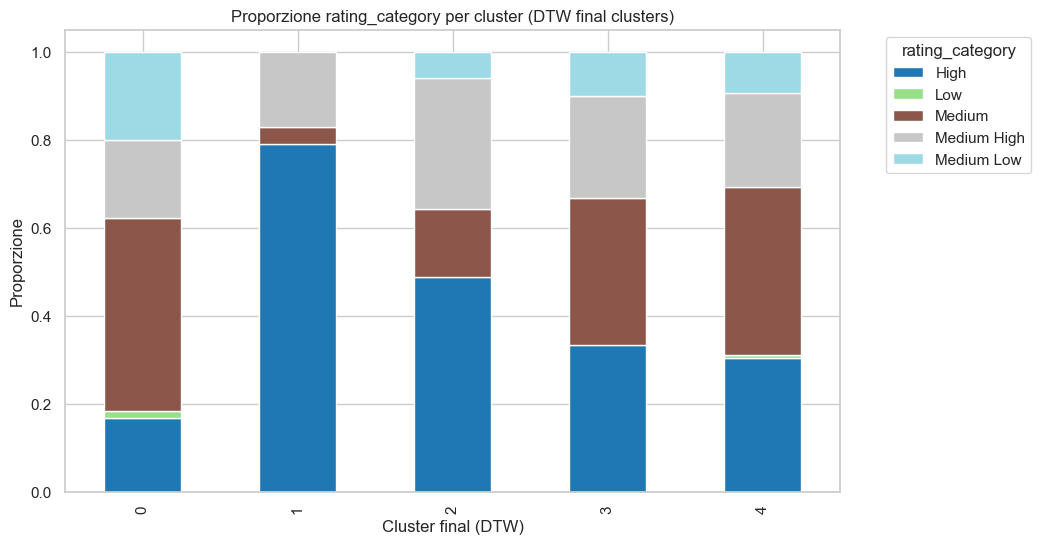

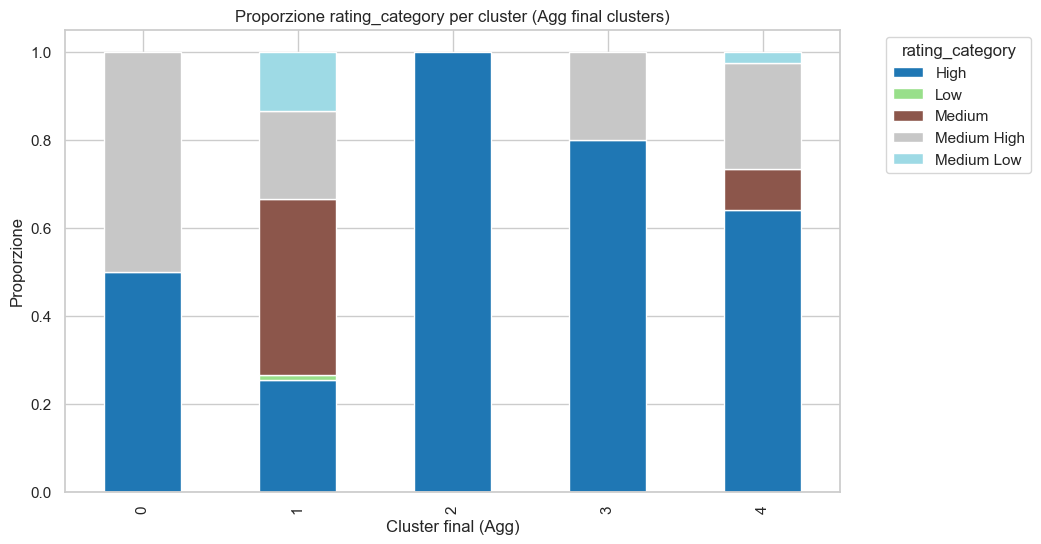

In [ ]:
# Cell 11 - rating_category distribution per cluster (stacked %)
df_for_plot = df.copy()

# DTW clusters
cluster_rating = df_for_plot.groupby(['cluster_final_dtw','rating_category']).size().unstack(fill_value=0)
cluster_rating_pct = cluster_rating.div(cluster_rating.sum(axis=1), axis=0)
ax = cluster_rating_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Proporzione rating_category per cluster (DTW final clusters)")
plt.xlabel("Cluster final (DTW)")
plt.ylabel("Proporzione")
plt.legend(title='rating_category', bbox_to_anchor=(1.05,1))
plt.show()

# Agg clusters
cluster_rating_agg = df_for_plot.groupby(['cluster_final_agg','rating_category']).size().unstack(fill_value=0)
cluster_rating_pct_agg = cluster_rating_agg.div(cluster_rating_agg.sum(axis=1), axis=0)
ax = cluster_rating_pct_agg.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Proporzione rating_category per cluster (Agg final clusters)")
plt.xlabel("Cluster final (Agg)")
plt.ylabel("Proporzione")
plt.legend(title='rating_category', bbox_to_anchor=(1.05,1))
plt.show()


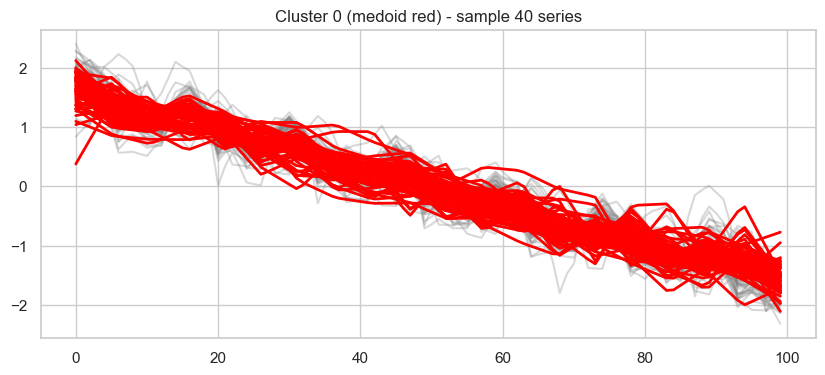

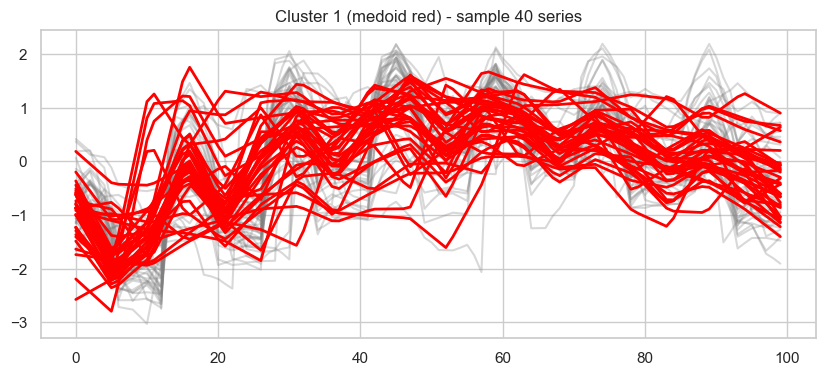

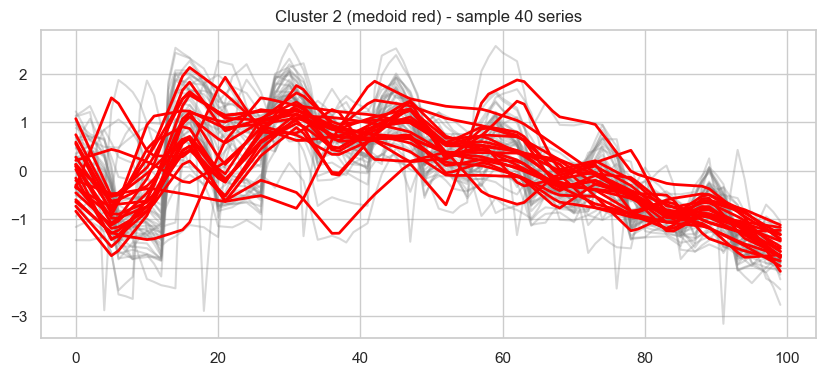

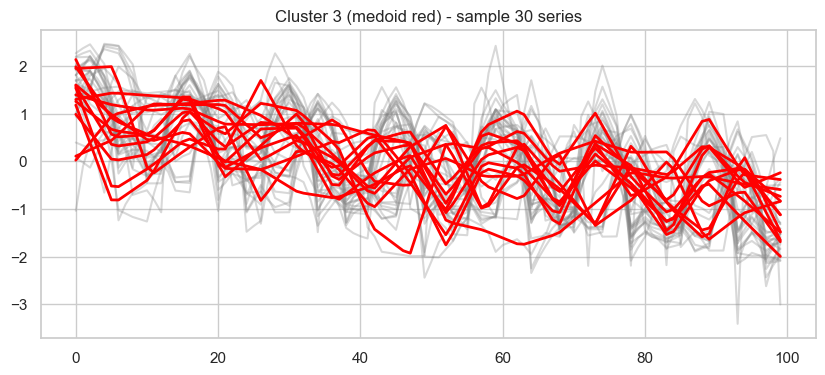

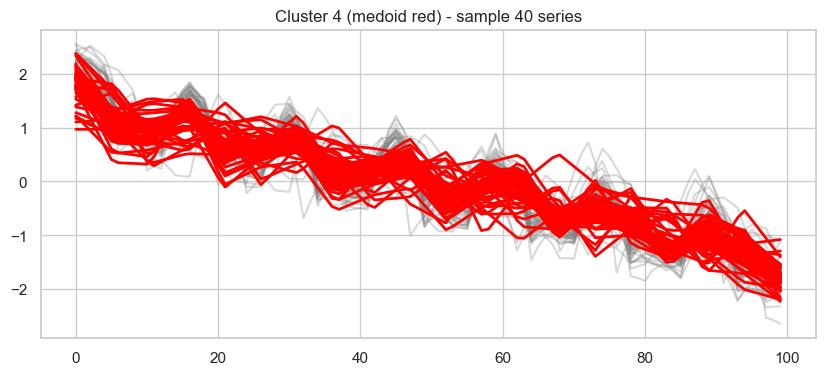

In [ ]:
# Cell 12 - Visual inspect: for each final cluster, show medoid + mean of members
def plot_cluster_summary(cluster_label, df, labels_full, cluster_label_name='cluster_final_dtw', n_samples_plot=40):
    idxs = np.where(labels_full == cluster_label)[0]
    if len(idxs) == 0:
        print("Empty cluster", cluster_label); return
    # sample members if too many
    sel = idxs if len(idxs) <= n_samples_plot else np.random.choice(idxs, n_samples_plot, replace=False)
    plt.figure(figsize=(10,4))
    for i in sel:
        plt.plot(X_z[i], color='gray', alpha=0.3)
    # medoid of micro-clusters belonging to this final cluster (reps)
    # find reps that were mapped to this final cluster
    reps_in_final = [rep_order[i] for i,l in enumerate(labels_reps_dtw) if l==cluster_label]
    # for each such micro-cluster, plot its medoid (reconstructed from PAA by interpolation)
    for rep_idx, rep_id in enumerate(rep_order):
        if labels_reps_dtw[rep_idx] == cluster_label:
            med = reps[rep_idx]
            x_med = np.linspace(0, ts_len-1, len(med))
            plt.plot(np.interp(np.arange(ts_len), x_med, med), color='red', lw=2)
    plt.title(f"Cluster {cluster_label} (medoid red) - sample {len(sel)} series")
    plt.show()

# Example: plot first 3 final clusters (DTW)
for c in range(min(5, k_final)):
    plot_cluster_summary(c, df, labels_final_full, 'cluster_final_dtw')


In [ ]:
def plot_embedding(X_emb, labels, title, info_labels=None):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_emb[:,0], X_emb[:,1], c=labels, cmap='tab10', s=60, edgecolor='k')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    # Aggiungi annotazioni se fornite
    if info_labels is not None:
        for i, txt in enumerate(info_labels):
            plt.annotate(txt, (X_emb[i,0], X_emb[i,1]), fontsize=9, alpha=0.7)
    
    plt.show()


In [ ]:
rating_category = df['rating_category'].values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_embedding(X_emb, clusters, info_labels, title):
    plt.figure(figsize=(8,6))
    markers = ['o','s','^','v','D','P','*','X','+','<']  # simboli diversi
    unique_labels = list(np.unique(info_labels))
    
    for i, label in enumerate(unique_labels):
        idx = info_labels == label
        plt.scatter(
            X_emb[idx,0], X_emb[idx,1], 
            c=clusters[idx], cmap='tab10', 
            marker=markers[i % len(markers)], 
            edgecolor='k', s=60, label=label
        )
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Rating Category")
    plt.show()


In [ ]:
reps_idx = np.array(rep_order)  # indices of the representatives in the original dataset

rating_category_reps = rating_category[reps_idx]

print("Rating category reps shape:", rating_category_reps.shape) 


Rating category reps shape: (200,)


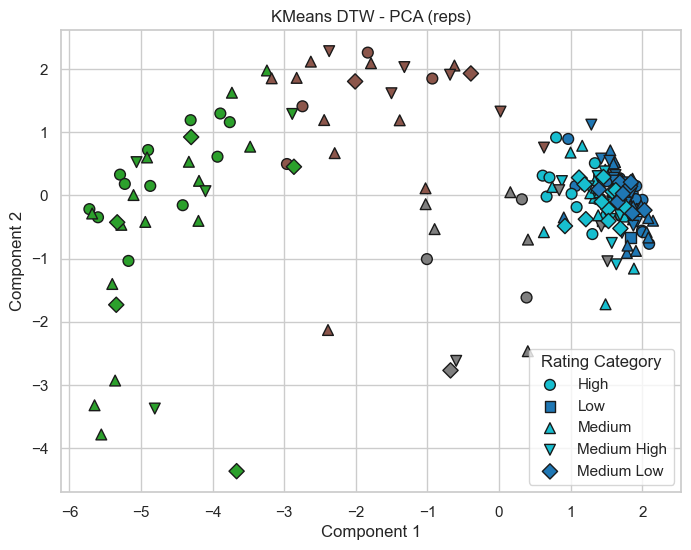

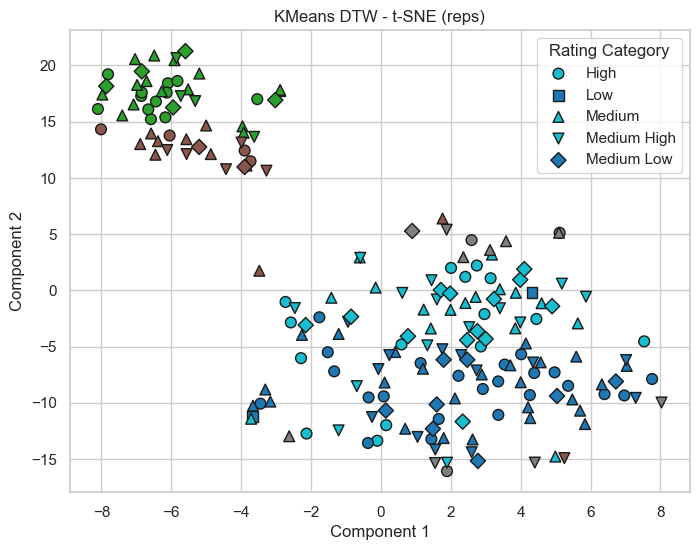

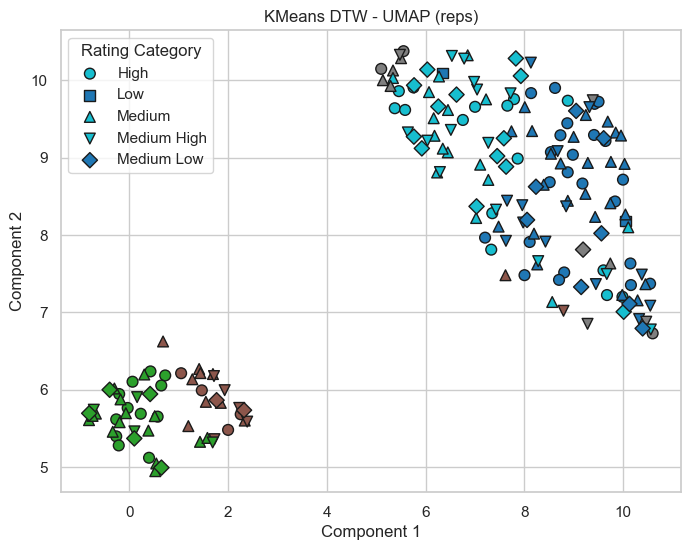

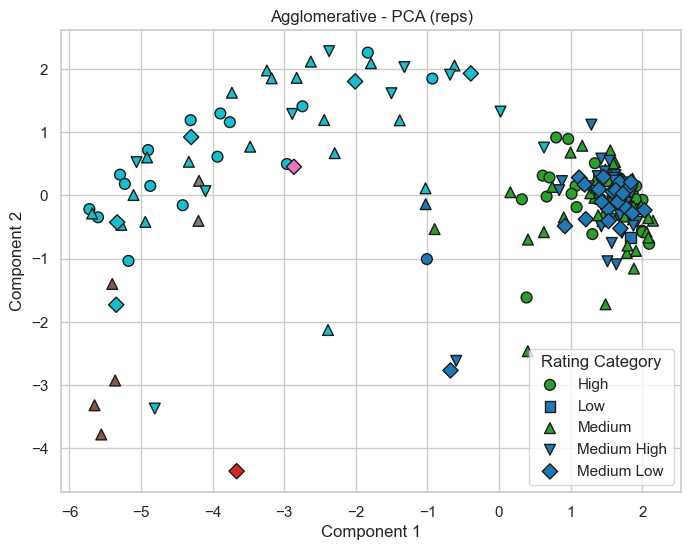

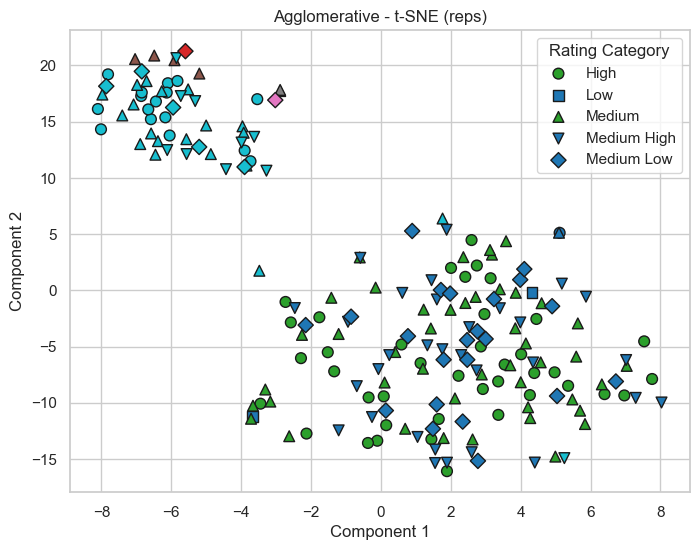

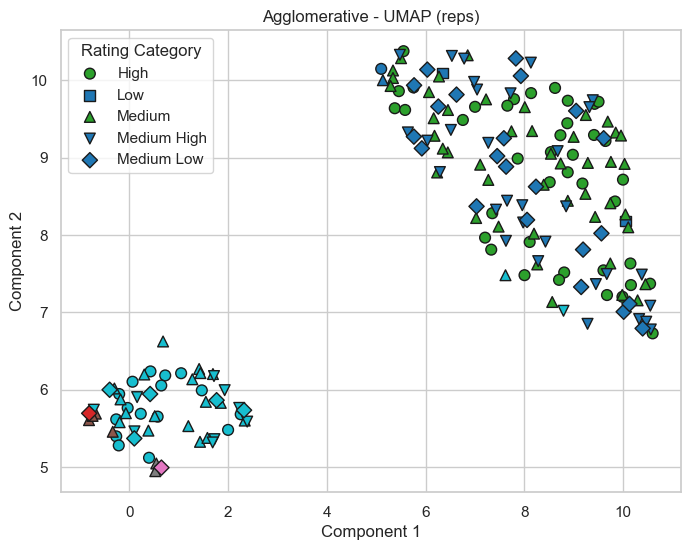

In [ ]:
# KMeans DTW
plot_embedding(reps_pca, labels_reps_dtw, rating_category_reps, "KMeans DTW - PCA (reps)")
plot_embedding(reps_tsne, labels_reps_dtw, rating_category_reps, "KMeans DTW - t-SNE (reps)")
plot_embedding(reps_umap, labels_reps_dtw, rating_category_reps, "KMeans DTW - UMAP (reps)")

# Agglomerative
plot_embedding(reps_pca, labels_reps_agg, rating_category_reps, "Agglomerative - PCA (reps)")
plot_embedding(reps_tsne, labels_reps_agg, rating_category_reps, "Agglomerative - t-SNE (reps)")
plot_embedding(reps_umap, labels_reps_agg, rating_category_reps, "Agglomerative - UMAP (reps)")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_embedding(X_emb, clusters, info_labels, title, cluster_name="Cluster", info_name="Rating Category"):
    plt.figure(figsize=(8,6))
    
    # Marker disponibili, si riciclano se categorie > numero marker
    markers = ['o','s','^','v','D','P','*','X','+','<']
    
    unique_info = np.unique(info_labels)
    
    for i, label in enumerate(unique_info):
        idx = info_labels == label
        plt.scatter(
            X_emb[idx,0], X_emb[idx,1],
            c=clusters[idx], cmap='tab10',
            marker=markers[i % len(markers)],
            edgecolor='k', s=80, alpha=0.8,
            label=label
        )
    
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title=info_name, bbox_to_anchor=(1.05, 1), loc='upper left')  # legenda fuori dal plot
    plt.tight_layout()
    plt.show()


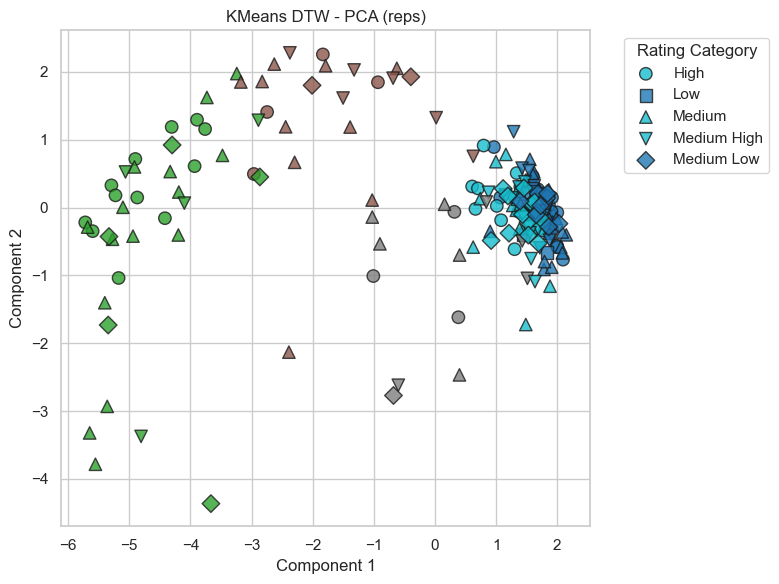

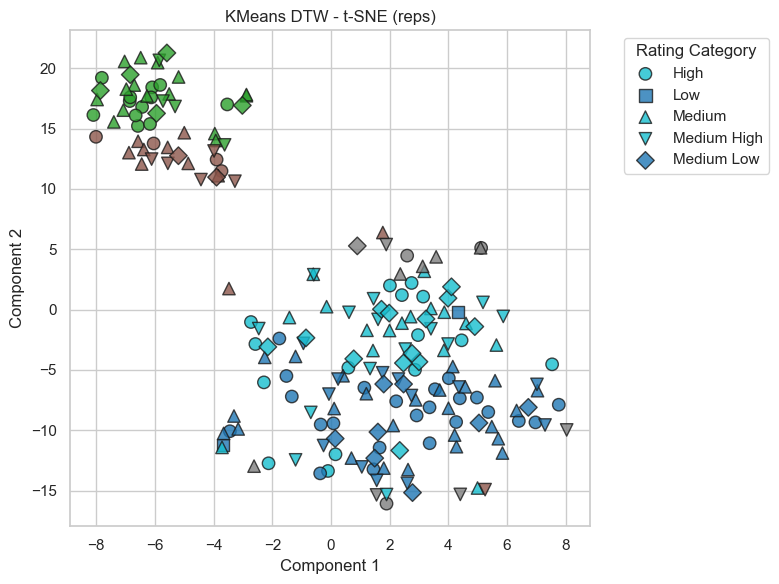

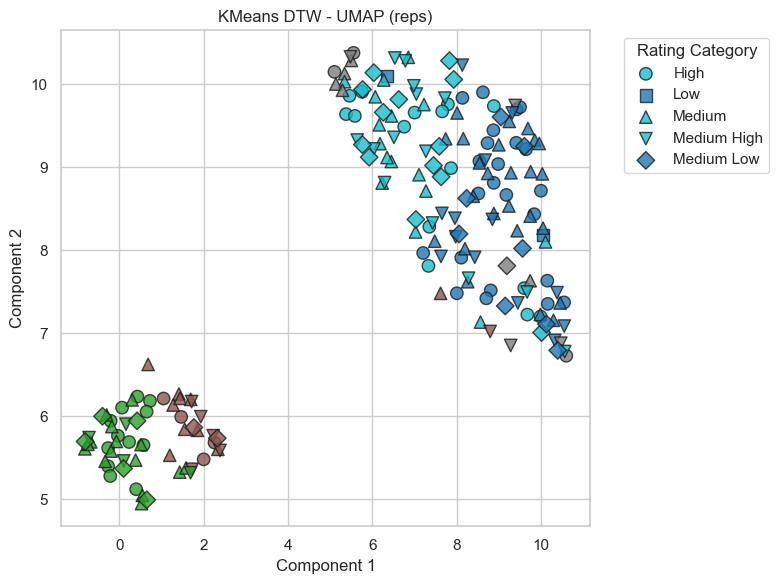

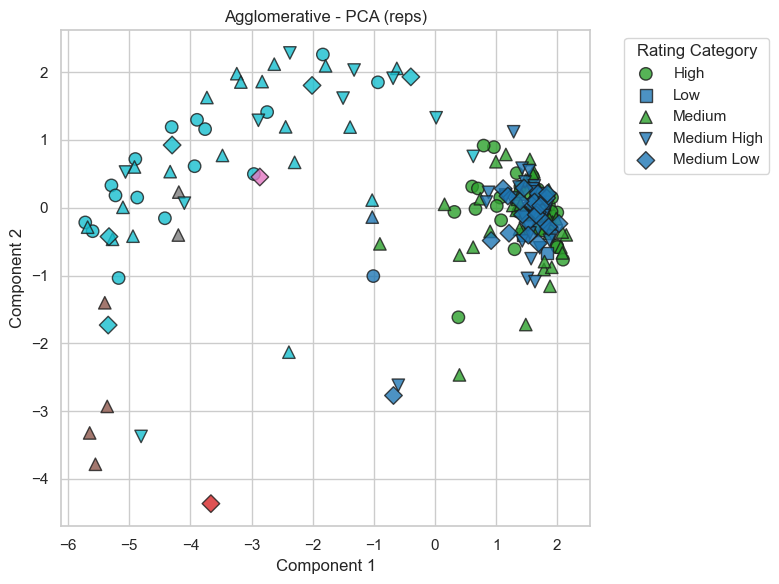

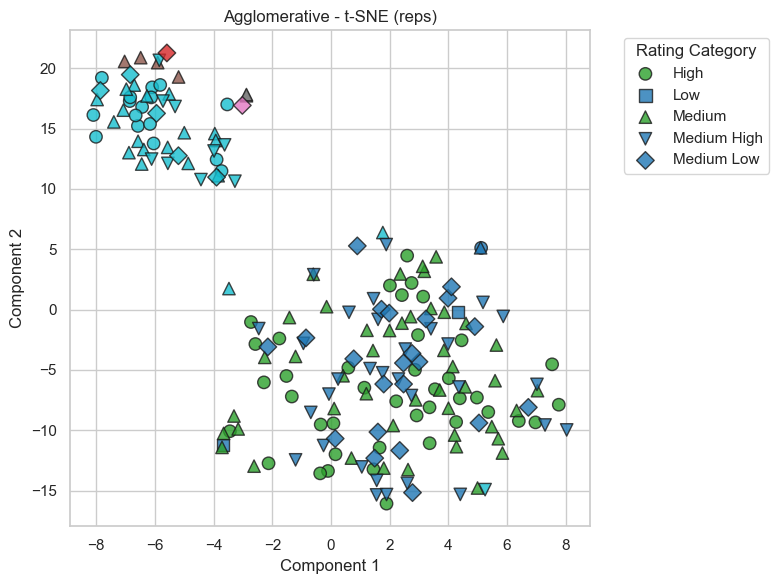

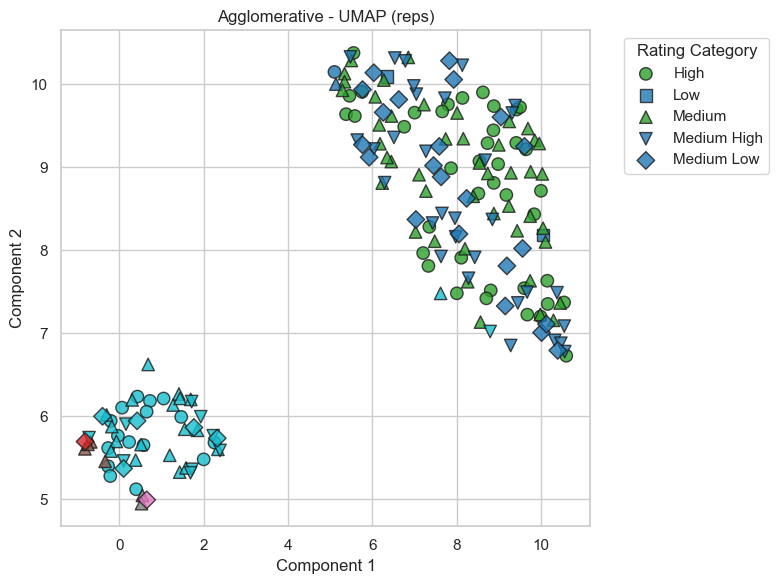

In [ ]:
# Rating category per i reps
rating_category_reps = rating_category[np.array(rep_order)]

# KMeans DTW
plot_embedding(reps_pca, labels_reps_dtw, rating_category_reps, "KMeans DTW - PCA (reps)")
plot_embedding(reps_tsne, labels_reps_dtw, rating_category_reps, "KMeans DTW - t-SNE (reps)")
plot_embedding(reps_umap, labels_reps_dtw, rating_category_reps, "KMeans DTW - UMAP (reps)")

# Agglomerative
plot_embedding(reps_pca, labels_reps_agg, rating_category_reps, "Agglomerative - PCA (reps)")
plot_embedding(reps_tsne, labels_reps_agg, rating_category_reps, "Agglomerative - t-SNE (reps)")
plot_embedding(reps_umap, labels_reps_agg, rating_category_reps, "Agglomerative - UMAP (reps)")


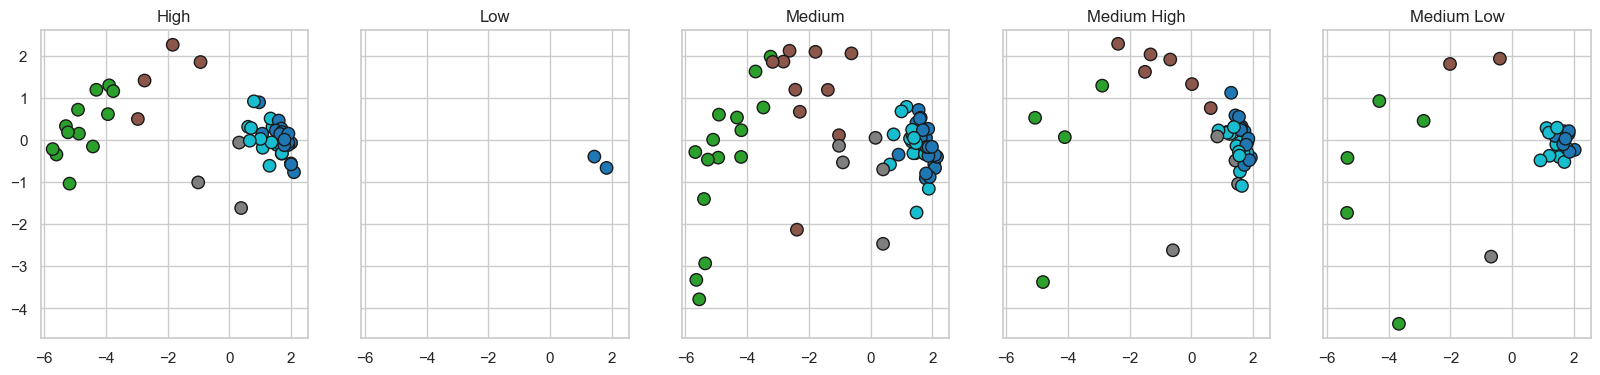

In [ ]:
categories = np.unique(rating_category_reps)
fig, axs = plt.subplots(1, len(categories), figsize=(4*len(categories), 4), sharex=True, sharey=True)
for ax, cat in zip(axs, categories):
    idx = rating_category_reps == cat
    ax.scatter(reps_pca[idx,0], reps_pca[idx,1], c=labels_reps_dtw[idx], cmap='tab10', s=80, edgecolor='k')
    ax.set_title(cat)
plt.show()


rating_category
Medium         387
High           377
Medium High    232
Medium Low     128
Low             10
Name: count, dtype: int64


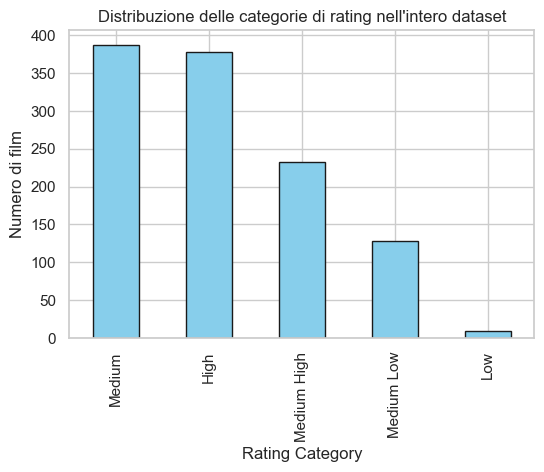

In [ ]:
rating_counts = df['rating_category'].value_counts()
print(rating_counts)

# Plot a barre
rating_counts.plot(kind='bar', figsize=(6,4), color='skyblue', edgecolor='k')
plt.title("Distribuzione delle categorie di rating nell'intero dataset")
plt.xlabel("Rating Category")
plt.ylabel("Numero di film")
plt.show()
